In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
import matplotlib.colors as cm
import utils_PLS as upls

volumes = ace.clean_volumes_database()

root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_wf_USV_Bedding_wb'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]


def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells_' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

thresholds = [500, 1500, 2500, 3500, 4500, 5500, 6500]

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [2]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['Control',
                                                       'USVC57',
                                                       'USVBALB',
                                                       'USVBALB_Bedding',
                                                       'USVC57_Bedding',
                                                       'Bedding'])
# keep only experimental groups Control and Bedding
experimental_groups = {key: experimental_groups[key] for key in ['Control', 'Bedding']}

In [3]:
subjects = experimental_groups['Control'] + experimental_groups['Bedding']

In [4]:
def sum_values(subjects, thresholds, data_directory):
    """
    Summarize various metrics (n_cells, energy, density, relative_density) for given subjects and thresholds.

    This function reads CSV files for each subject and threshold, sums the specified metrics, and compiles the
    results into a single DataFrame.

    Parameters:
    subjects (list): List of subjects (e.g., ['subject1', 'subject2']).
    thresholds (list): List of thresholds (e.g., [1, 2, 3]).
    data_directory (str): Directory path where the subject data files are located.

    Returns:
    pd.DataFrame: A DataFrame containing summed values for each metric, subject, and threshold.
    """
    
    # Initialize an empty DataFrame with the specified columns
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])
    
    # Create a list of subjects repeated for each threshold
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    
    # Create a list of thresholds repeated for each subject
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]
    
    # Iterate through each metric and calculate the sum for each subject and threshold
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        data[metric] = [pd.read_csv(f"{data_directory}/{subject}/{subject}{threshold}.csv")[metric].sum()
                        for subject in subjects for threshold in thresholds]
    
    return data

In [5]:
def plot_values(data, palette='Set2'):
    """
    Plot various metrics (n_cells, energy, density, relative_density) for given subjects and thresholds.

    This function creates a 2x2 grid of line plots for the specified metrics. Each line plot shows the values
    of a metric across subjects, colored by threshold.

    Parameters:
    data (pd.DataFrame): DataFrame containing columns 'subject', 'threshold', 'n_cells', 'energy', 'density', and 'relative_density'.
    palette (str): Color palette for the line plots.

    Returns:
    None
    """
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.06)  # Adjust vertical space between plots

    # Plot for 'n_cells' metric
    sns.lineplot(data=data, x='subject', y='n_cells', hue='threshold', ax=axes[0][0], 
                 legend=False, palette=palette, marker="o")
    axes[0][0].tick_params(labelbottom=False)  # Remove x-axis labels for this plot
    axes[0][0].set_xlabel('')  # Remove x-axis label

    # Plot for 'energy' metric
    sns.lineplot(data=data, x='subject', y='energy', hue='threshold', ax=axes[0][1], 
                 palette=palette, marker="o")
    axes[0][1].legend().set_title('')  # Remove legend title
    axes[0][1].tick_params(labelbottom=False)  # Remove x-axis labels for this plot
    axes[0][1].set_xlabel('')  # Remove x-axis label

    # Plot for 'density' metric
    sns.lineplot(data=data, x='subject', y='density', hue='threshold', ax=axes[1][0], 
                 legend=False, palette=palette, marker="o")
    axes[1][0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
    axes[1][0].set_xlabel('')  # Remove x-axis label

    # Plot for 'relative_density' metric
    sns.lineplot(data=data, x='subject', y='relative_density', hue='threshold', ax=axes[1][1], 
                 legend=False, palette=palette, marker="o")
    axes[1][1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
    axes[1][1].set_xlabel('')  # Remove x-axis label

    # Display the plot
    plt.show()


In [6]:
def find_significant_areas(dictionary, experimental_groups, groups=['Control', 'Fam', 'Unfam'], 
                           test='mannwhitneyu'):
    """
    Find significant brain areas based on non-parametric statistical tests.

    This function calculates cell counts across experimental groups, performs a non-parametric test 
    (Mann-Whitney U by default) to compare groups, and identifies significant brain areas by 
    evaluating p-values. Significant areas are determined based on a p-value threshold (< 0.05).

    Parameters:
    dictionary (dict): A dictionary containing cell count data for each subject.
    experimental_groups (dict): A dictionary mapping experimental groups to their respective subjects.
    groups (list of str): A list of group names to compare. Default is ['Control', 'Fam', 'Unfam'].
    test (str): The statistical test to use. Default is 'mannwhitneyu'.

    Returns:
    pd.DataFrame: A DataFrame listing significant brain areas for each comparison.
    """
    # Calculate cell counts across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value='n_cells')
    
    # Perform statistical tests across groups
    df_ttest = ace.test_across_groups(dfs, groups=groups, test=test)
    
    # Identify significant areas based on p-values
    columns = df_ttest.loc[:, df_ttest.columns != 'area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        # Select areas with p-value < 0.05
        significant_areas = df[df[col] < 0.05]['area'].reset_index(drop=True)
        df_sigareas = pd.concat([df_sigareas, significant_areas], axis=1)
    
    # Rename columns to reflect the comparisons
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    
    return df_sigareas


In [7]:
def calculate_ratio_detected_cells(subjects, thresholds, data_directory):
    """
    Calculate the ratio of analyzed cells to detected cells for given subjects and thresholds.

    This function computes the ratio of the number of cells analyzed to the number of cells 
    detected for a list of subjects across various thresholds. It uses the summed cell counts 
    from the `sum_values` function and reads the detected cell counts from CSV files.

    Parameters:
    subjects (list): List of subject identifiers.
    thresholds (list): List of threshold values used for analysis.

    Returns:
    pd.DataFrame: A DataFrame containing the subject, threshold, number of cells analyzed,
                  number of detected cells, and the ratio of analyzed to detected cells.
    """
    # Initialize an empty DataFrame to store the results
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells_analysis', 'n_detected_cells', 'ratio'])

    # Get the summed values for each subject and threshold
    data_sum = sum_values(subjects=subjects, thresholds=thresholds, data_directory=data_directory)

    # Populate the DataFrame with subject and threshold information
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]

    # Initialize lists to store the analyzed and detected cell counts, and their ratio
    n_cells = []
    n_detected_cells = []
    ratio = []

    # Calculate the number of analyzed and detected cells, and the ratio
    for subject in subjects:
        for threshold in thresholds:
            # Get the total number of analyzed cells for the given subject and threshold
            sum_n = data_sum[(data_sum['subject'] == subject) & 
                             (data_sum['threshold'] == threshold)]['n_cells'].item()
            n_cells.append(sum_n)

            # Read the number of detected cells from the CSV file
            det_n = len(pd.read_csv(data_directory + subject + '/cells_' + str(threshold) + '.csv',
                                    low_memory=False))
            n_detected_cells.append(det_n)

            # Calculate the ratio of analyzed to detected cells
            ratio.append(sum_n / det_n)

    # Store the calculated values in the DataFrame
    data['n_cells_analysis'] = n_cells
    data['n_detected_cells'] = n_detected_cells
    data['ratio'] = ratio

    return data


In [8]:
def dataframe_areas(area, subjects, thresholds):
    """
    Create a DataFrame for a specific brain area across different subjects and thresholds.

    This function constructs a DataFrame containing various metrics (n_cells, energy, density, 
    relative_density) for a specified brain area. The data is collected for multiple subjects 
    and thresholds by reading corresponding CSV files.

    Parameters:
    area (str): The specific brain area of interest.
    subjects (list): A list of subject identifiers.
    thresholds (list): A list of threshold values used for analysis.

    Returns:
    pd.DataFrame: A DataFrame with columns 'subject', 'threshold', 'n_cells', 'energy', 
                  'density', and 'relative_density', containing data for the specified area.
    """
    # Initialize the DataFrame with appropriate columns
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])

    # Populate the 'subject' and 'threshold' columns
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]

    # Iterate over the metrics and collect data
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        values = []
        for subject in subjects:
            for threshold in thresholds:
                # Read the CSV file for the current subject and threshold
                v = pd.read_csv(data_directory + subject + '/' + subject + str(threshold) + '.csv')
                # Extract the value for the specified area and metric
                values.append(v[v['area'] == area][metric].values[0])
        # Assign the collected values to the DataFrame for the current metric
        data[metric] = values

    return data


# Plot ratio of detected cells over cells used for analysis

In [9]:
ratio = calculate_ratio_detected_cells(subjects=subjects, 
                                       thresholds=thresholds,
                                      data_directory=data_directory)

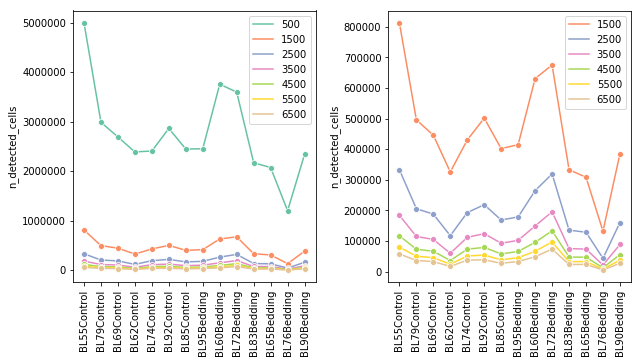

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.lineplot(data=ratio, x='subject', y='n_detected_cells', hue='threshold', ax=axes[0], 
             legend=True, palette='Set2', marker="o")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].legend().set_title('')

cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
sns.lineplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', hue='threshold', ax=axes[1], legend=True
            , palette=cmap, marker="o")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].legend().set_title('')

Text(0.5, 1.0, 'Excluding threshold 500')

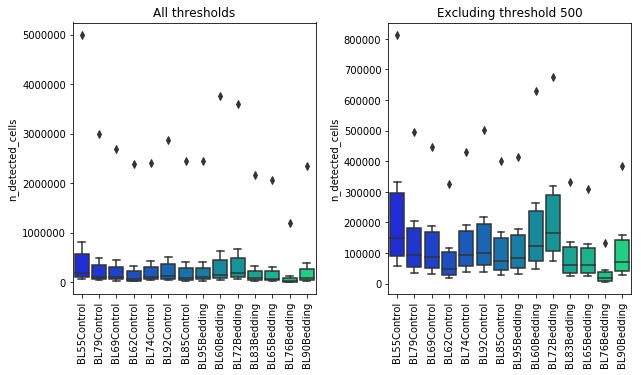

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='subject', y='n_detected_cells', ax=axes[0], 
             palette='winter')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].set_title('All thresholds')

sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', ax=axes[1], 
            palette='winter')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].set_title('Excluding threshold 500')

Text(0.5, 0, '')

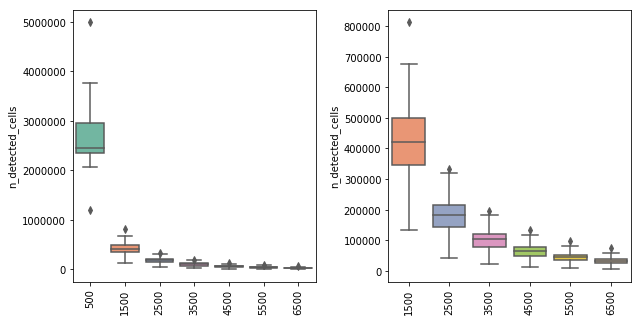

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='threshold', y='n_detected_cells', ax=axes[0], 
             palette='Set2')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='threshold', y='n_detected_cells', ax=axes[1], 
            palette=cmap)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')

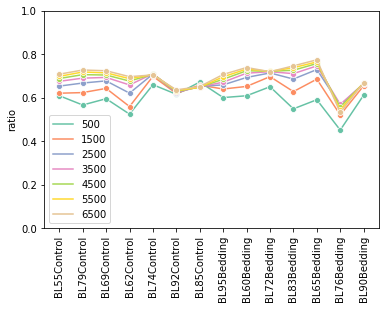

In [13]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.lineplot(data=ratio, x='subject', y='ratio', hue='threshold', ax=axes, legend=True, palette='Set2', marker="o")
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])
plt.gca().legend().set_title('')

(0, 1)

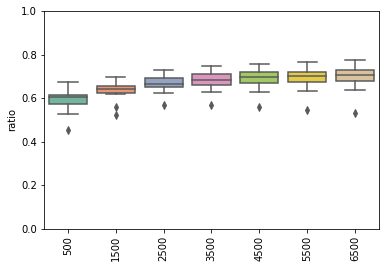

In [14]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.boxplot(data=ratio, x='threshold', y='ratio', ax=axes, palette='Set2')
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])

# Plot total number of cells

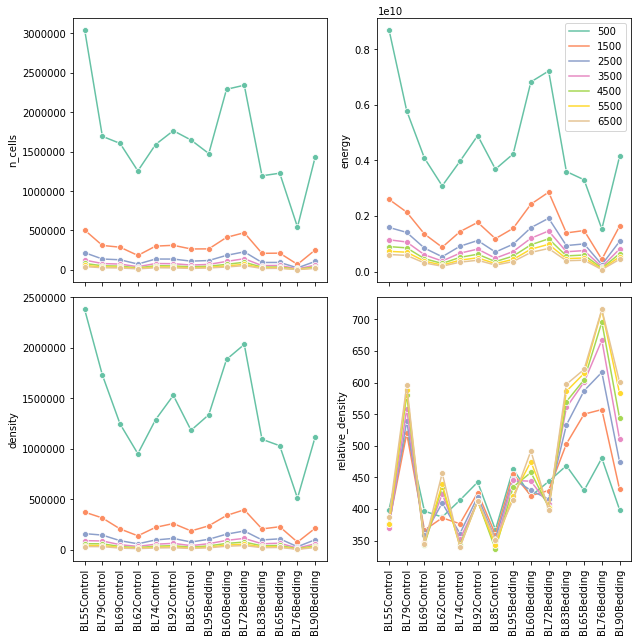

In [15]:
data = sum_values(subjects=subjects, thresholds=thresholds, data_directory=data_directory)

plot_values(data)

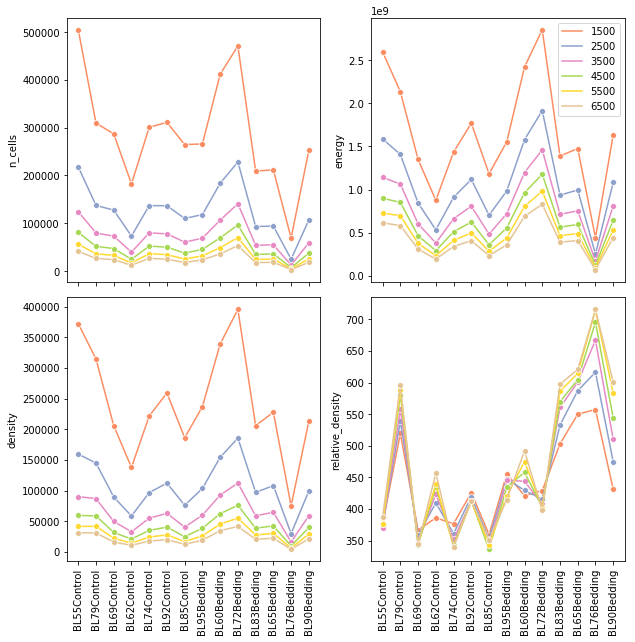

In [17]:
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = sum_values(subjects=subjects, thresholds=thresholds[1:], data_directory=data_directory)

plot_values(data, palette=cmap)

# Plot single areas

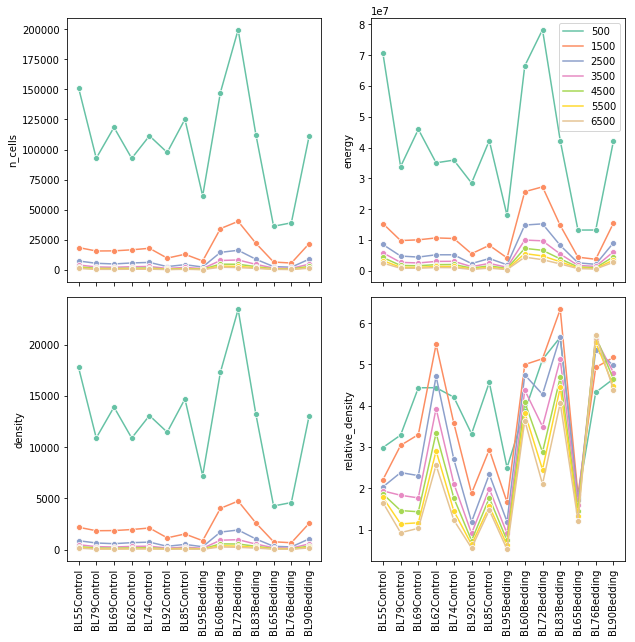

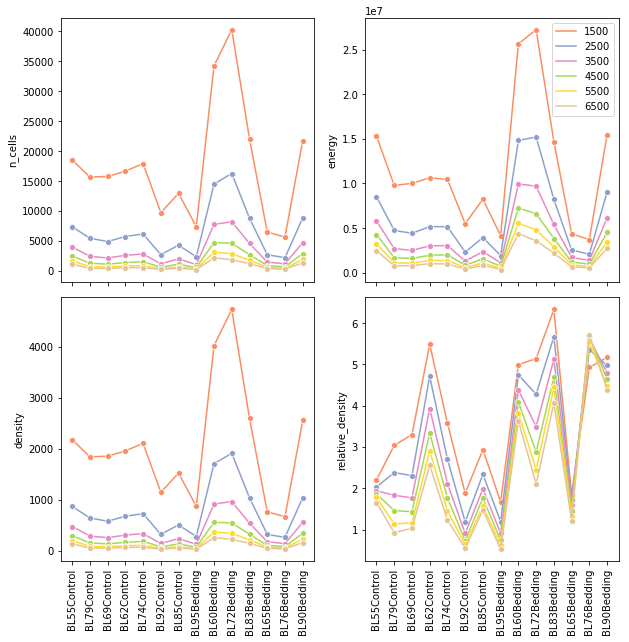

In [20]:
data = dataframe_areas(area="Main olfactory bulb",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Main olfactory bulb",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


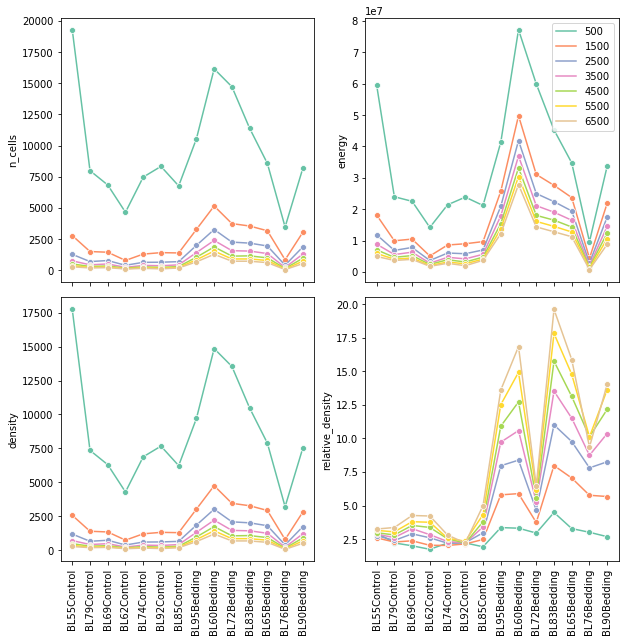

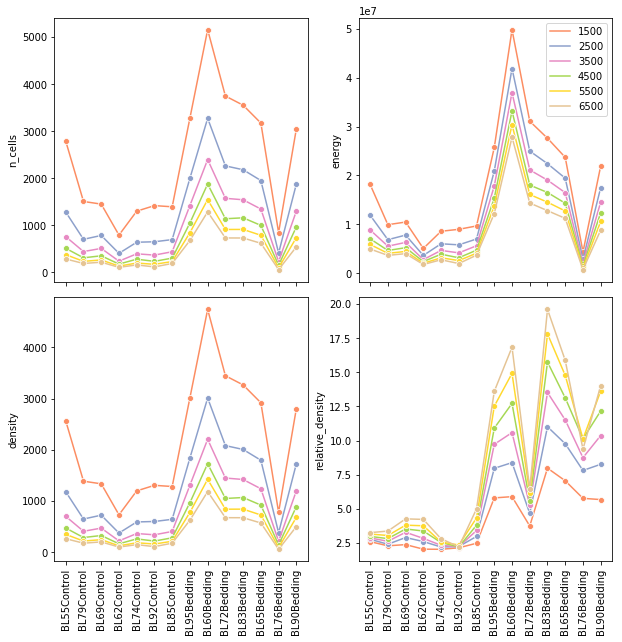

In [21]:
data = dataframe_areas(area="Medial amygdalar nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Medial amygdalar nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


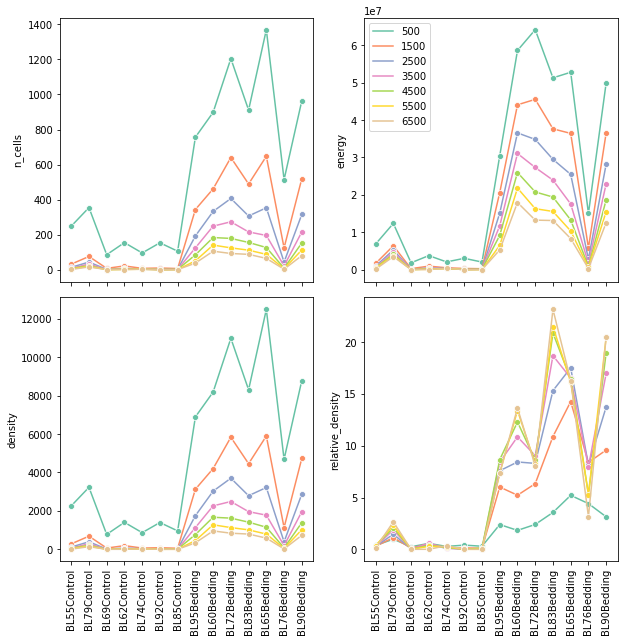

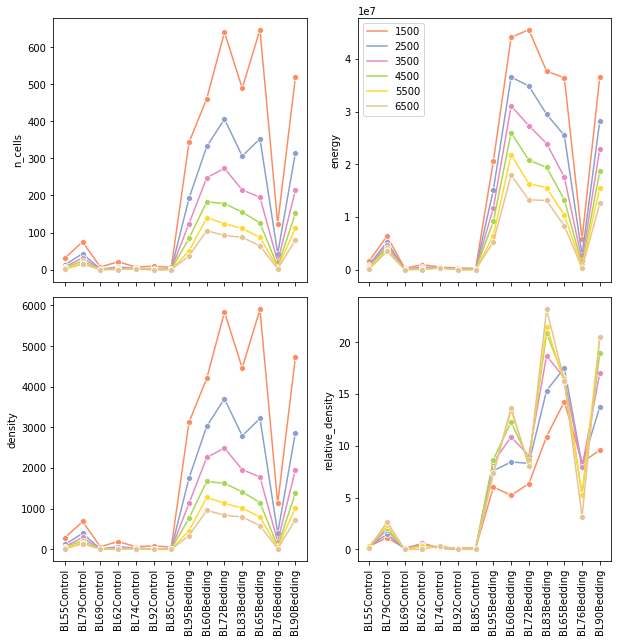

In [22]:
data = dataframe_areas(area="Ventral premammillary nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Ventral premammillary nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


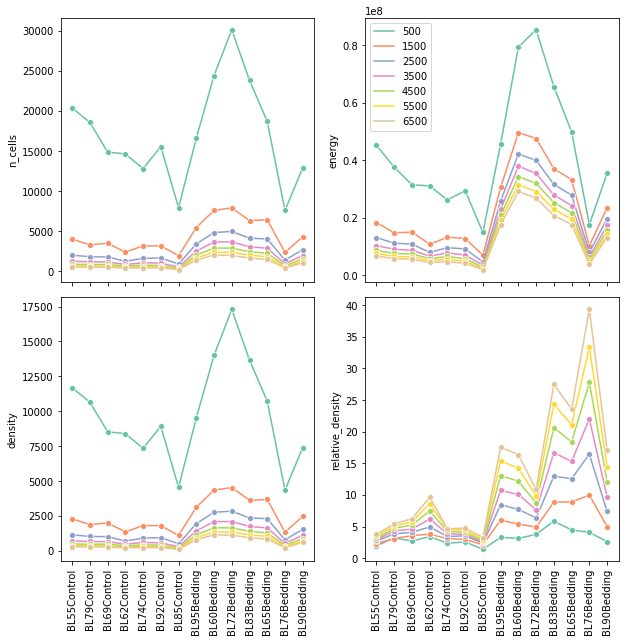

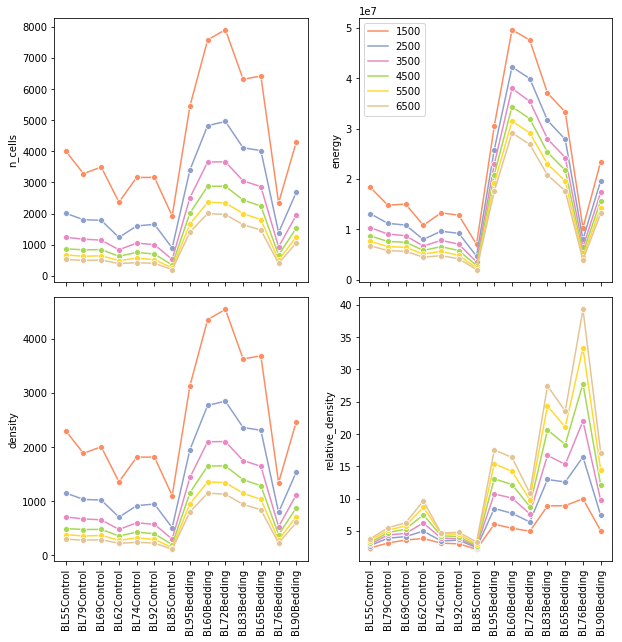

In [18]:
data = dataframe_areas(area="Cortical amygdalar area",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Cortical amygdalar area",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


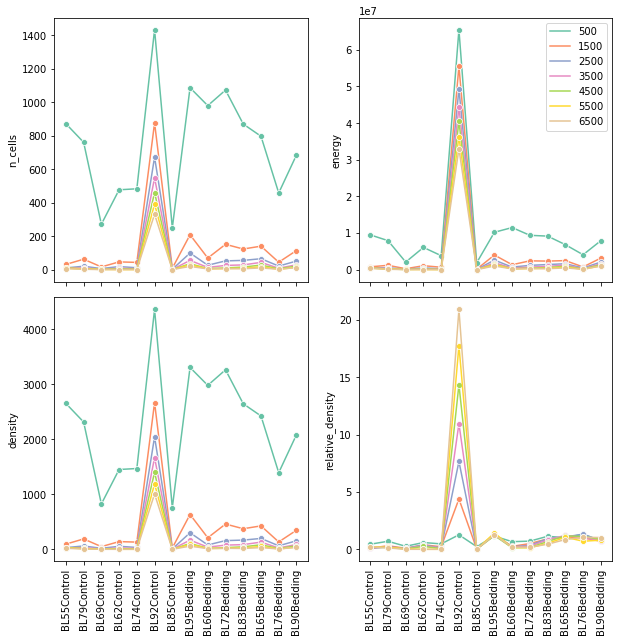

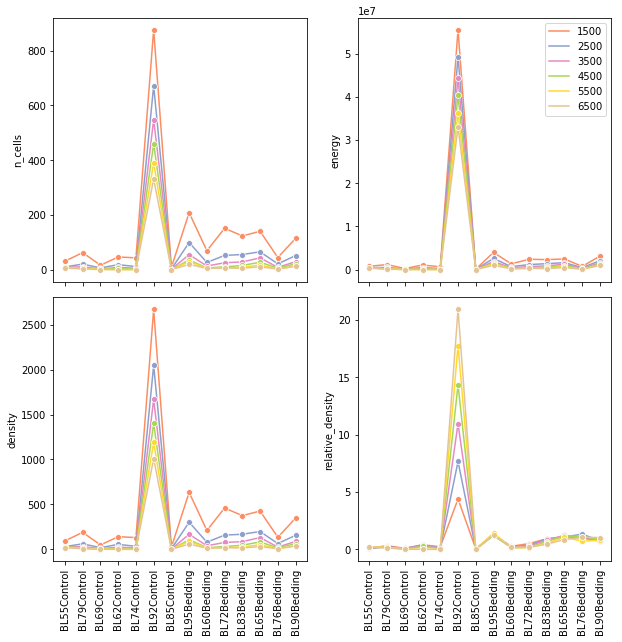

In [19]:
data = dataframe_areas(area="Arcuate hypothalamic nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Arcuate hypothalamic nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


# T-test for mean area activation across groups

In [23]:
dict500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(500)+'.csv')
                            for subject in subjects}
df_sigareas500 = find_significant_areas(dictionary=dict500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas500

,Control_vs_Bedding
0,Posterodorsal preoptic nucleus
1,Ventral premammillary nucleus
2,Anterior amygdalar area
3,Magnocellular nucleus
4,Fundus of striatum
5,Parabigeminal nucleus
6,Frontal pole cerebral cortex
7,Substantia innominata
8,Supraoptic nucleus
9,Interanteromedial nucleus of the thalamus


In [24]:
dict1500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(1500)+'.csv')
                            for subject in subjects}
df_sigareas1500 = find_significant_areas(dictionary=dict1500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas1500

,Control_vs_Bedding
0,Posterodorsal preoptic nucleus
1,Ventral premammillary nucleus
2,Accessory olfactory bulb
3,Medial preoptic nucleus
4,Anteroventral periventricular nucleus
5,Magnocellular nucleus
6,Posterior amygdalar nucleus
7,Periventricular hypothalamic nucleus posterior...
8,Fundus of striatum
9,Tuberal nucleus


In [25]:
dict2500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(2500)+'.csv')
                            for subject in subjects}
df_sigareas2500 = find_significant_areas(dictionary=dict2500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas2500

,Control_vs_Bedding
0,Posterodorsal preoptic nucleus
1,Accessory olfactory bulb
2,Ventral premammillary nucleus
3,Anteroventral periventricular nucleus
4,Magnocellular nucleus
5,Tuberal nucleus
6,Medial preoptic nucleus
7,Posterior amygdalar nucleus
8,Periventricular hypothalamic nucleus posterior...
9,Substantia nigra compact part


In [26]:
dict3500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(3500)+'.csv')
                            for subject in subjects}
df_sigareas3500 = find_significant_areas(dictionary=dict3500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas3500

,Control_vs_Bedding
0,Accessory olfactory bulb
1,Ventral premammillary nucleus
2,Magnocellular nucleus
3,Anteroventral periventricular nucleus
4,Posterodorsal preoptic nucleus
5,Tuberal nucleus
6,Medial preoptic nucleus
7,Posterior amygdalar nucleus
8,Cortical amygdalar area
9,Substantia nigra compact part


In [27]:
dict4500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(4500)+'.csv')
                            for subject in subjects}
df_sigareas4500 = find_significant_areas(dictionary=dict4500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas4500

,Control_vs_Bedding
0,Accessory olfactory bulb
1,Ventral premammillary nucleus
2,Anteroventral periventricular nucleus
3,Posterior amygdalar nucleus
4,Medial preoptic nucleus
5,Periventricular hypothalamic nucleus preoptic ...
6,Tuberal nucleus
7,Posterodorsal preoptic nucleus
8,Substantia nigra compact part
9,Cortical amygdalar area


In [28]:

dict5500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(5500)+'.csv')
                            for subject in subjects}
df_sigareas5500 = find_significant_areas(dictionary=dict5500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas5500

,Control_vs_Bedding
0,Accessory olfactory bulb
1,Ventral premammillary nucleus
2,Medial preoptic nucleus
3,Posterior amygdalar nucleus
4,Anteroventral periventricular nucleus
5,Periventricular hypothalamic nucleus preoptic ...
6,Parastrial nucleus
7,Tuberal nucleus
8,Cortical amygdalar area
9,Piriform-amygdalar area


In [29]:
dict6500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(6500)+'.csv')
                            for subject in subjects}
df_sigareas6500 = find_significant_areas(dictionary=dict6500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Bedding'])
df_sigareas6500

,Control_vs_Bedding
0,Accessory olfactory bulb
1,Ventral premammillary nucleus
2,Posterior amygdalar nucleus
3,Periventricular hypothalamic nucleus preoptic ...
4,Magnocellular nucleus
5,Substantia innominata
6,Cortical amygdalar area
7,Anteroventral periventricular nucleus
8,Medial preoptic nucleus
9,Tuberal nucleus


## Find common areas across all thresholds

In [30]:
# common areas in Control_vs_Fam
common_areas = {tag: 
list(set(df_sigareas500[tag].dropna()).intersection(
df_sigareas1500[tag].dropna()).intersection(
df_sigareas2500[tag].dropna()).intersection(
df_sigareas3500[tag].dropna()).intersection(
df_sigareas4500[tag].dropna()))
                for tag in df_sigareas500.columns}
common_areas

{'Control_vs_Bedding': ['Substantia nigra reticular part',
  'Piriform-amygdalar area',
  'Posterodorsal preoptic nucleus',
  'Posterior auditory area',
  'Fundus of striatum',
  'Lateral visual area',
  'Nucleus accumbens',
  'Substantia innominata',
  'Periventricular hypothalamic nucleus posterior part',
  'Ventral premammillary nucleus',
  'Magnocellular nucleus']}

## Number of significant areas

In [31]:
number_sig_area = pd.DataFrame(columns=['threshold']+ [col for col in df_sigareas500.columns])
for df, t in zip([df_sigareas500,
                df_sigareas1500,
                df_sigareas2500,
                df_sigareas3500,
                df_sigareas4500,
                df_sigareas5500,
                df_sigareas6500],
                thresholds):
    number_sig_area.loc[len(number_sig_area.index)] = [t, 
                                                       len(df['Control_vs_Bedding'].dropna())]

Text(0.5, 0, '')

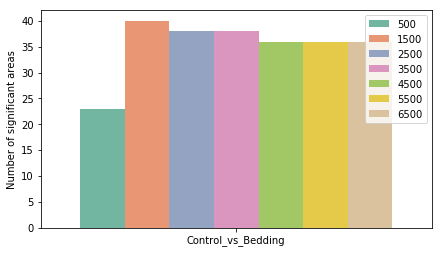

In [32]:
plot_number_sig_area = number_sig_area.set_index('threshold').stack()\
    .reset_index(name='Number of significant areas').rename(columns={'level_1':'group'})

fig, axes = plt.subplots(1,1, figsize=(7,4))
sns.barplot(data=plot_number_sig_area, x='group',
            y='Number of significant areas', hue='threshold', ax=axes, palette='Set2')
axes.legend().set_title('')
axes.set_xlabel('')


## Find common areas across all thresholds

In [33]:
# common areas in Control_vs_Fam
common_areas = {tag: 
list(set(df_sigareas500[tag].dropna()).intersection(
df_sigareas1500[tag].dropna()).intersection(
df_sigareas2500[tag].dropna()).intersection(
df_sigareas3500[tag].dropna()).intersection(
df_sigareas4500[tag].dropna()).intersection(
df_sigareas5500[tag].dropna()).intersection(
df_sigareas6500[tag].dropna())
    )
                for tag in df_sigareas500.columns}
common_areas

{'Control_vs_Bedding': ['Piriform-amygdalar area',
  'Posterodorsal preoptic nucleus',
  'Fundus of striatum',
  'Lateral visual area',
  'Nucleus accumbens',
  'Substantia innominata',
  'Periventricular hypothalamic nucleus posterior part',
  'Ventral premammillary nucleus',
  'Magnocellular nucleus']}

# Correlation matrices

In [34]:
def corr_matrix(experimental_groups,
               dict_results_across_mice,
               value='n_cells'):
    n_groups = len(experimental_groups.keys())
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    # rename areas with acronyms
    for df in dfs:
        for i in df.index:
            df.at[i, 'area'] = volumes[volumes['safe_name'] == \
                                       df.at[i, 'area']]['acronym'].values[0]
    # remove null values
    for df in dfs:
        df = df.set_index('area').loc[
                ~(df.set_index('area')==0).all(axis=1)].dropna(axis=0)
    
    df1, df2 = dfs
    # fix here loop of intersections
    indexes_intersect = df1.index.intersection(df2.index)
    print(indexes_intersect)
    corr_matrices = []
    for df in dfs:
        df = df.loc[indexes_intersect]
        # check here why it is empty
        corr_matrices.append(df.set_index('area').T.corr(method='pearson'))
    return corr_matrices

In [35]:
corr_matrices = [corr_matrix(experimental_groups=experimental_groups,
                           dict_results_across_mice=dictionary) for dictionary in [dict500, 
                                                                                   dict1500,
                                                                                   dict2500,
                                                                                   dict3500,
                                                                                   dict4500,
                                                                                   dict5500,
                                                                                   dict6500]] 

RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)


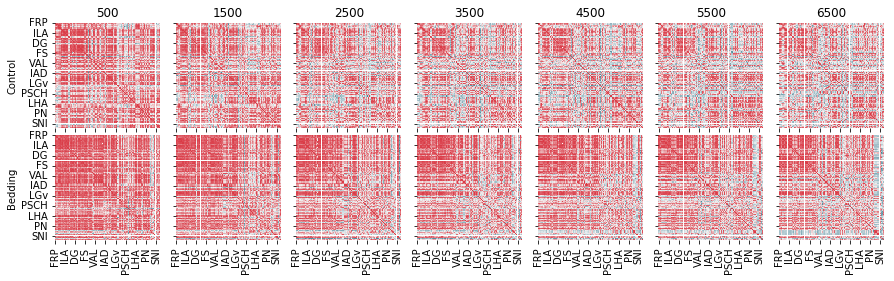

In [36]:
f, ax = plt.subplots(2,7, figsize=(15, 4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.07, wspace=0.07)
group_labels = ['Control', 'Bedding']
for i, threshold in enumerate(corr_matrices):
    for j, matrix in enumerate(threshold):
        sns.heatmap(matrix,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0,
        square=True, cbar=False, ax=ax[j][i])
        ax[j][i].set_xlabel('')
        ax[j][i].set_ylabel('') if i!=0 else ax[j][i].set_ylabel(group_labels[j])
        if j==0:
            ax[j][i].set_title(str(thresholds[i]))

# Analysis Task PLS

In [37]:
df_levels = upls.create_df_levels(volumes, level=8)
for i, dictionary in enumerate([dict500,dict1500,dict2500,dict3500,dict4500,dict5500,dict6500]):
    dictionary = upls.reformat_dict_acronym(dict_results=dictionary,
                                            volumes=volumes)
    data_relative_density = upls.format_data_pls(dict_results=dictionary, 
                                                 batch='BL_wf_USV_Bedding_wb'+str(thresholds[i]), 
                                                 table='relative_density')
    data_relative_density.dropna(inplace=True, axis=1)
    data_relative_density.to_csv('./results_pls/BL_wf_USV_Bedding_wb'+str(thresholds[i])\
                                 +'_relative_density.csv')

In [38]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb500_relative_density'

In [39]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb1500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb1500_relative_density'

In [40]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb2500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb2500_relative_density'

In [41]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb3500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb3500_relative_density'

In [42]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb4500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb4500_relative_density'

In [43]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb5500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb5500_relative_density'

In [44]:
%%bash
python area_pls.py -i results_pls/BL_wf_USV_Bedding_wb6500_relative_density.csv -o './results_pls/BL_wf_USV_Bedding_wb6500_relative_density'

In [45]:
# for t in thresholds:
#     upls.plot_panel_contrasts(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density')
#     upls.plot_panel_saliences(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density', 
#                               df_levels=df_levels)

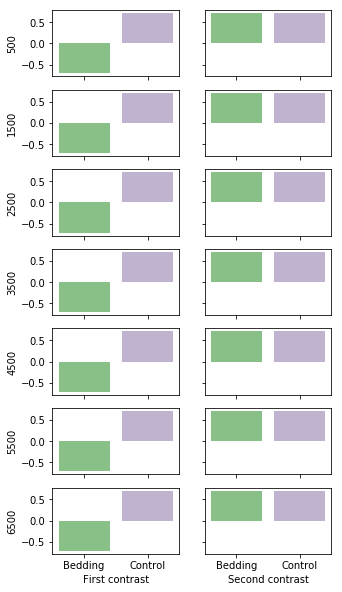

In [46]:
fig, axes = plt.subplots(7,2, figsize=(5,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    contrasts = pd.read_csv('./results_pls/'+ 'BL_wf_USV_Bedding_wb'+str(thresholds[i])+\
                            '_relative_density_contrasts.csv')
    contrasts = contrasts.rename(columns={"group_Control": "Control",
                                          "group_Bedding": "Bedding"})
    for j in range(2):
        upls.plot_contrasts(df_data=contrasts, index=j, ax=axes[i][j], palette='Accent')
        axes[i][j].set_xlabel(['First contrast',
                                  'Second contrast'][j]) if i == 6 else axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel(thresholds[i]) if j == 0 else axes[i][j].set_ylabel('')


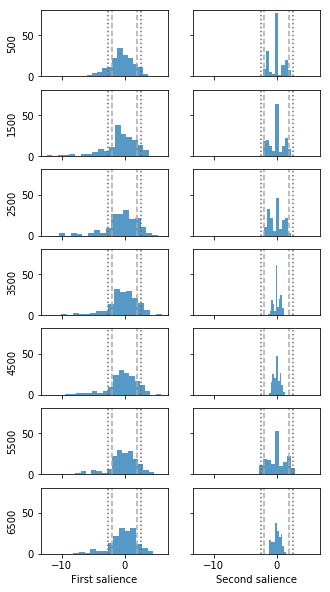

In [47]:
fig, axes = plt.subplots(7,2, figsize=(5,10), sharex=True, sharey=True)
plt.rcParams['patch.edgecolor'] = 'none'
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_USV_Bedding_wb'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    for j in range(2):
        sns.histplot(saliences.T[j], ax=axes[i][j])
        axes[i][j].axvline(x=1.96, linestyle='--', color='darkgrey')
        axes[i][j].axvline(x=-1.96, linestyle='--', color='darkgrey')
        axes[i][j].axvline(x=2.56, linestyle=':', color='dimgrey')
        axes[i][j].axvline(x=-2.56, linestyle=':', color='dimgrey')
        axes[i][j].set_xlabel(['First salience',
                                  'Second salience',
                                  'Third salience'][j])    
        if j==0:
            axes[i][j].set_ylabel(thresholds[i])

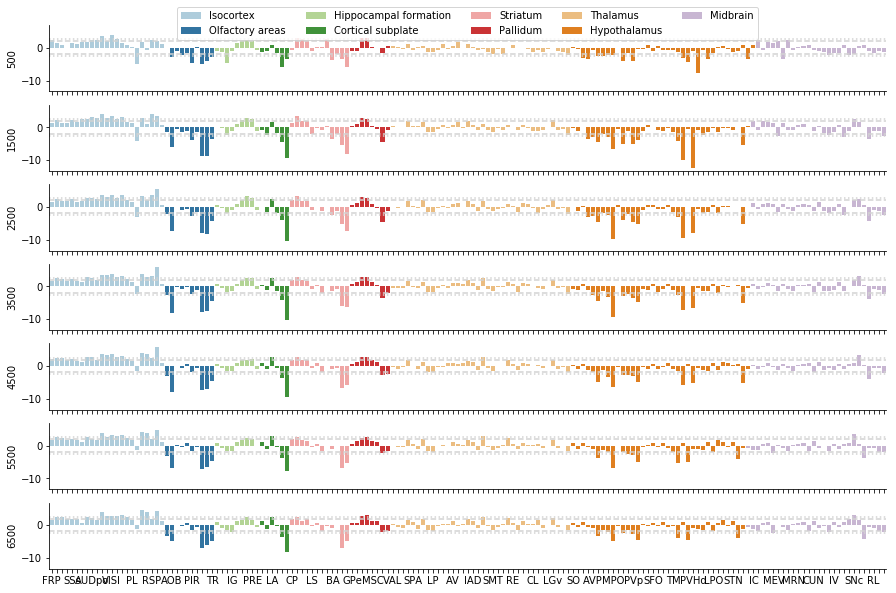

In [48]:
df_levels = upls.create_df_levels(volumes, level=8)
fig, axes = plt.subplots(7,1, figsize=(15,10), sharex=True, sharey=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_USV_Bedding_wb'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=0, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=-1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=2.56, linestyle=':', color='lightgrey')
    axes[i].axhline(y=-2.56, linestyle=':', color='lightgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
axes[0].legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.35),
ncol=5)

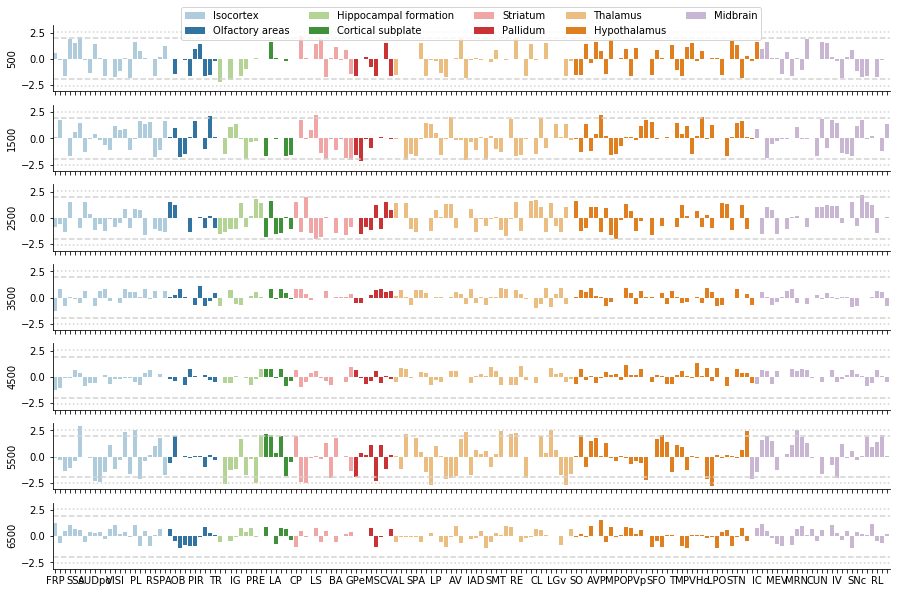

In [49]:
df_levels = upls.create_df_levels(volumes, level=8)
fig, axes = plt.subplots(7,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_USV_Bedding_wb'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=1, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=-1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=2.56, linestyle=':', color='lightgrey')
    axes[i].axhline(y=-2.56, linestyle=':', color='lightgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
axes[0].legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.35),
ncol=5)

In [50]:
experimental_groups

{'Control': ['BL55Control',
  'BL79Control',
  'BL69Control',
  'BL62Control',
  'BL74Control',
  'BL92Control',
  'BL85Control'],
 'Bedding': ['BL95Bedding',
  'BL60Bedding',
  'BL72Bedding',
  'BL83Bedding',
  'BL65Bedding',
  'BL76Bedding',
  'BL90Bedding']}

# Kruskall-Wallis test

In [51]:
# remove two mice excluded from analysis
experimental_groups['Control'].remove('BL55Control')
experimental_groups['Bedding'].remove('BL76Bedding')

In [52]:
dict2500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(2500)+'.csv', index_col=0)
                            for subject in subjects}
del dict2500['BL55Control']
del dict2500['BL76Bedding']

kr_2500 = ace.kruskal_per_area(dictionary=dict2500,
                 experimental_groups=experimental_groups,
                 value='n_cells', level=8)
kr_2500

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Infralimbic area': (KruskalResult(statistic=5.769230769230774, pvalue=0.01630917187775491),
            Bedding   Control
  Bedding  1.000000  0.016309
  Control  0.016309  1.000000),
 'Accessory olfactory bulb': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform area': (KruskalResult(statistic=5.409941520467845, pvalue=0.02002238675086676),
            Bedding   Control
  Bedding  1.000000  0.020022
  Control  0.020022  1.000000),
 'Cortical amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform-amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Postpiriform transition area': (KruskalResult(

In [53]:
dict3500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(3500)+'.csv', index_col=0)
                            for subject in subjects}
del dict3500['BL55Control']
del dict3500['BL76Bedding']

kr_3500 = ace.kruskal_per_area(dictionary=dict3500,
                 experimental_groups=experimental_groups,
                 value='n_cells', level=8)
kr_3500

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Infralimbic area': (KruskalResult(statistic=5.025641025641029, pvalue=0.024974679293054206),
            Bedding   Control
  Bedding  1.000000  0.024975
  Control  0.024975  1.000000),
 'Accessory olfactory bulb': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Cortical amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform-amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Postpiriform transition area': (KruskalResult(statistic=8.336842105263164, pvalue=0.0038849066221194814),
            Bedding   Control
  Bedding  1.000000  0.003885
  Control  0.003885  1.000000),
 'Basomedial amygdalar nucleus

In [54]:
dict4500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(4500)+'.csv', index_col=0)
                            for subject in subjects}
del dict4500['BL55Control']
del dict4500['BL76Bedding']

kr_4500 = ace.kruskal_per_area(dictionary=dict4500,
                 experimental_groups=experimental_groups,
                 value='n_cells', level=8)
kr_4500

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Infralimbic area': (KruskalResult(statistic=5.025641025641029, pvalue=0.024974679293054206),
            Bedding   Control
  Bedding  1.000000  0.024975
  Control  0.024975  1.000000),
 'Accessory olfactory bulb': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Cortical amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform-amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Postpiriform transition area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Basomedial amygdalar nucleus'

In [55]:
dict5500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(5500)+'.csv', index_col=0)
                            for subject in subjects}
del dict5500['BL55Control']
del dict5500['BL76Bedding']

kr_5500 = ace.kruskal_per_area(dictionary=dict5500,
                 experimental_groups=experimental_groups,
                 value='n_cells', level=8)
kr_5500

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Infralimbic area': (KruskalResult(statistic=5.025641025641029, pvalue=0.024974679293054206),
            Bedding   Control
  Bedding  1.000000  0.024975
  Control  0.024975  1.000000),
 'Accessory olfactory bulb': (KruskalResult(statistic=8.366197183098597, pvalue=0.0038226470545864484),
            Bedding   Control
  Bedding  1.000000  0.003823
  Control  0.003823  1.000000),
 'Cortical amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform-amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Postpiriform transition area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Induseum griseum': (KruskalR

In [56]:
dict6500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(6500)+'.csv', index_col=0)
                            for subject in subjects}
del dict6500['BL55Control']
del dict6500['BL76Bedding']

kr_6500 = ace.kruskal_per_area(dictionary=dict6500,
                 experimental_groups=experimental_groups,
                 value='n_cells', level=8)
kr_6500

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Infralimbic area': (KruskalResult(statistic=5.025641025641029, pvalue=0.024974679293054206),
            Bedding   Control
  Bedding  1.000000  0.024975
  Control  0.024975  1.000000),
 'Accessory olfactory bulb': (KruskalResult(statistic=8.336842105263164, pvalue=0.0038849066221194814),
            Bedding   Control
  Bedding  1.000000  0.003885
  Control  0.003885  1.000000),
 'Cortical amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Piriform-amygdalar area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Postpiriform transition area': (KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446),
            Bedding   Control
  Bedding  1.000000  0.003948
  Control  0.003948  1.000000),
 'Induseum griseum': (KruskalR

## Check overlap across thresholds

In [57]:
# Number of significant areas across thresholds
len(kr_2500.keys()), len(kr_3500.keys()), len(kr_4500.keys()), len(kr_5500.keys()), len(kr_6500.keys())

(29, 23, 25, 26, 27)

In [58]:
len(set(kr_2500.keys()).intersection(kr_3500.keys()))

22

In [59]:
len(set(kr_3500.keys()).intersection(kr_4500.keys()))

22

In [60]:
len(set(kr_5500.keys()).intersection(kr_6500.keys()))

25

In [61]:
# Intersection across all thresholds
len(set(kr_2500.keys()).intersection(kr_3500.keys()).intersection(set(kr_4500.keys())).intersection(set(kr_5500.keys())).intersection(set(kr_6500.keys())))

20

In [62]:
set(kr_2500.keys()).intersection(kr_3500.keys()).intersection(set(kr_4500.keys())).intersection(set(kr_5500.keys())).intersection(set(kr_6500.keys()))

{'Accessory olfactory bulb',
 'Anteroventral periventricular nucleus',
 'Basomedial amygdalar nucleus',
 'Bed nuclei of the stria terminalis',
 'Cortical amygdalar area',
 'Infralimbic area',
 'Intercalated amygdalar nucleus',
 'Interfascicular nucleus raphe',
 'Medial amygdalar nucleus',
 'Medial preoptic area',
 'Medial preoptic nucleus',
 'Midbrain trigeminal nucleus',
 'Periventricular hypothalamic nucleus posterior part',
 'Periventricular hypothalamic nucleus preoptic part',
 'Piriform-amygdalar area',
 'Posterior amygdalar nucleus',
 'Posterodorsal preoptic nucleus',
 'Postpiriform transition area',
 'Tuberal nucleus',
 'Ventral premammillary nucleus'}

### Check the areas that are not significant in every test

In [63]:
set(kr_2500.keys()).union(kr_3500.keys()).union(set(kr_4500.keys())).union(set(kr_5500.keys())).union(set(kr_6500.keys())).difference(
set(kr_2500.keys()).intersection(kr_3500.keys()).intersection(set(kr_4500.keys())).intersection(set(kr_5500.keys())).intersection(set(kr_6500.keys())))

{'Anterodorsal preoptic nucleus',
 'Bed nucleus of the accessory olfactory tract',
 'Central linear nucleus raphe',
 'Dorsal nucleus raphe',
 'Fundus of striatum',
 'Induseum griseum',
 'Lateral dorsal nucleus of thalamus',
 'Lateral habenula',
 'Magnocellular nucleus',
 'Median preoptic nucleus',
 'Parastrial nucleus',
 'Piriform area',
 'Septohippocampal nucleus',
 'Substantia innominata',
 'Substantia nigra compact part',
 'Ventral tegmental nucleus',
 'Ventromedial hypothalamic nucleus'}